# Section 1: Importing Libraries

In this section, I import the necessary libraries for data handling, visualization, model building, and evaluation.  
I also set the Seaborn style for consistent plot aesthetics.


In [13]:
# SECTION 1 : Importing Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

# Suppress warnings for clearer output
warnings.filterwarnings("ignore")

# Scikit-learn modules for data preparation and modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

# TensorFlow/Keras modules for building neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Set Seaborn style for consistent plots
sns.set(style="whitegrid")


## Mounting Google Drive

I mount Google Drive to Colab to access the dataset and save outputs.


In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Section 2: Data Preparation and Exploratory Data Analysis (EDA)

In this section, I load the CKD dataset, clean and preprocess the data, handle missing values using KNN imputation, encode categorical variables, define CKD stages, and split the data for training and testing.  
I also perform basic exploratory data analysis (EDA) by plotting feature distributions, boxplots, and the CKD stage distribution.



Loading and Preparing Dataset...
Original dataset shape: (400, 26)

Missing values BEFORE coercing to numeric:
 id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                71
wc                106
rc                131
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

Missing values AFTER coercing to numeric:
 id                  0
age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu              

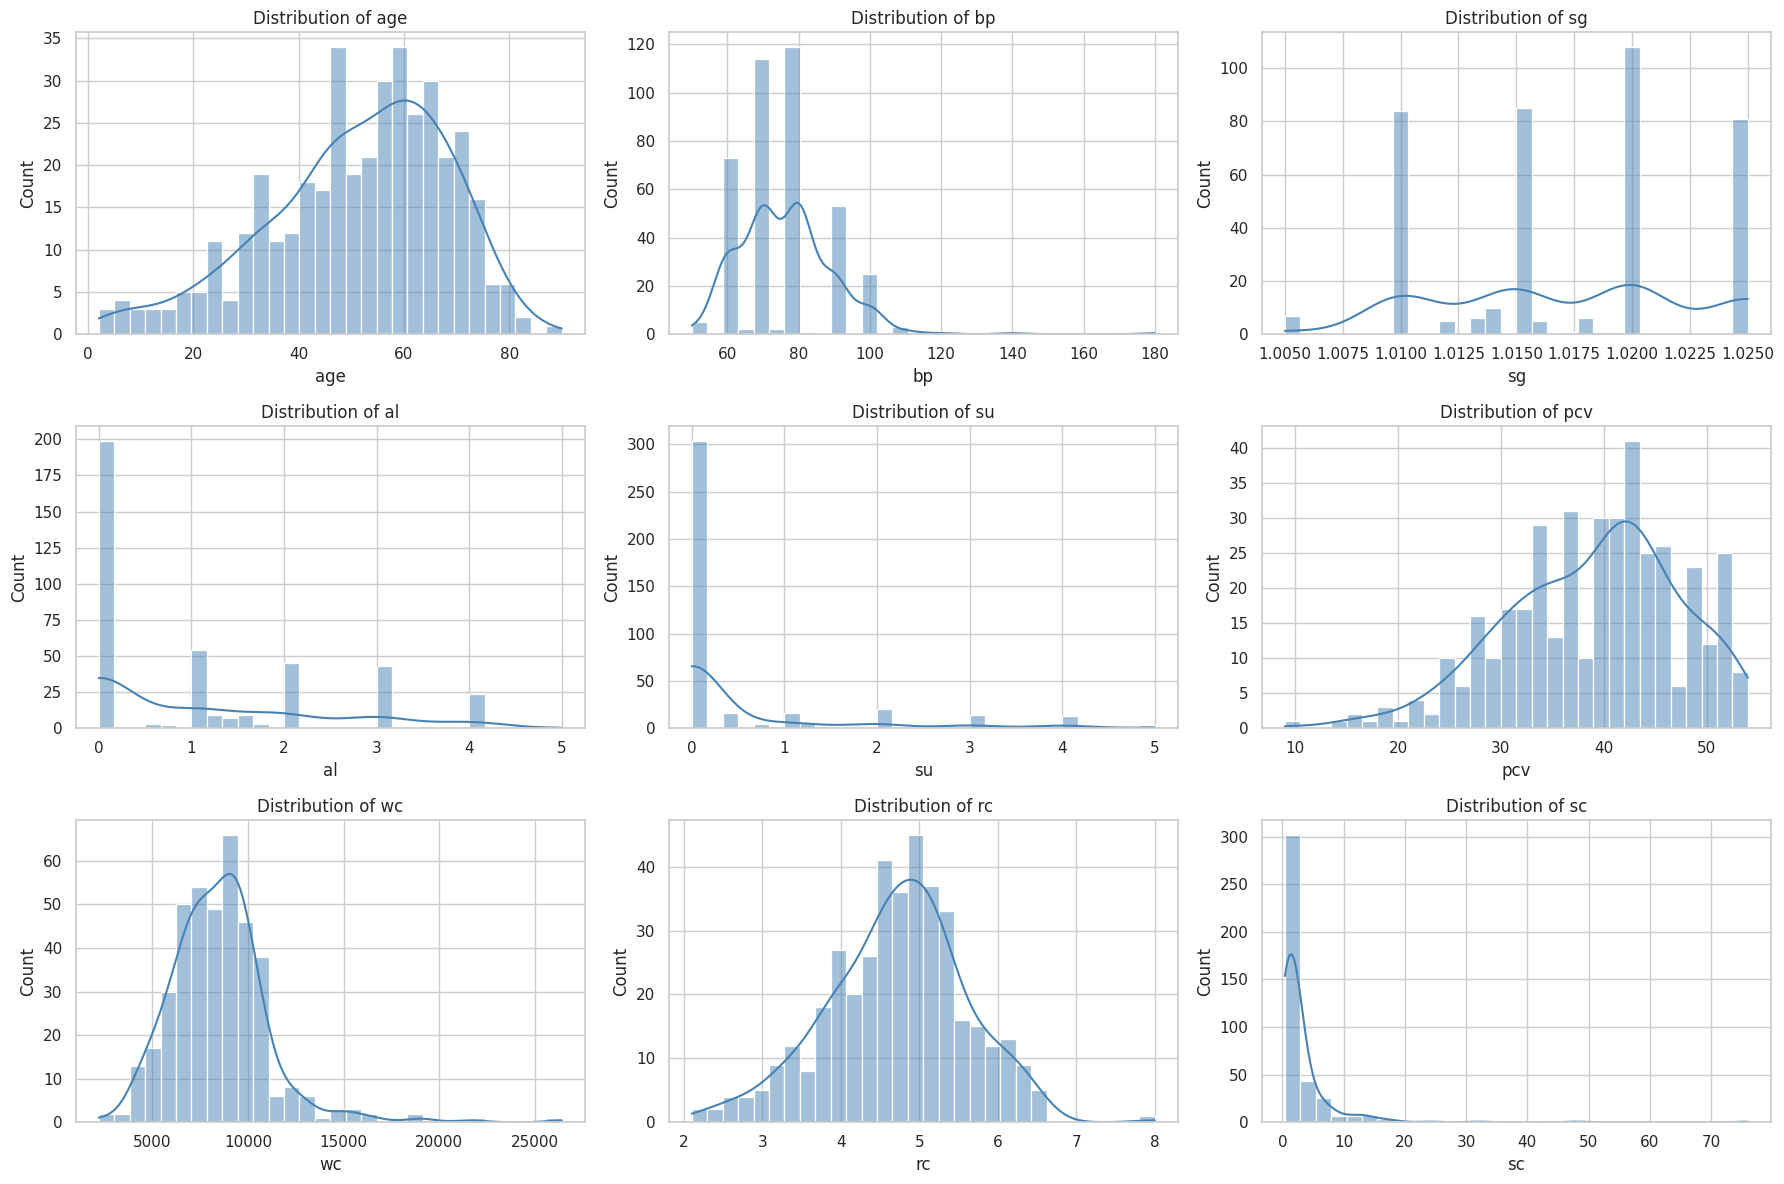

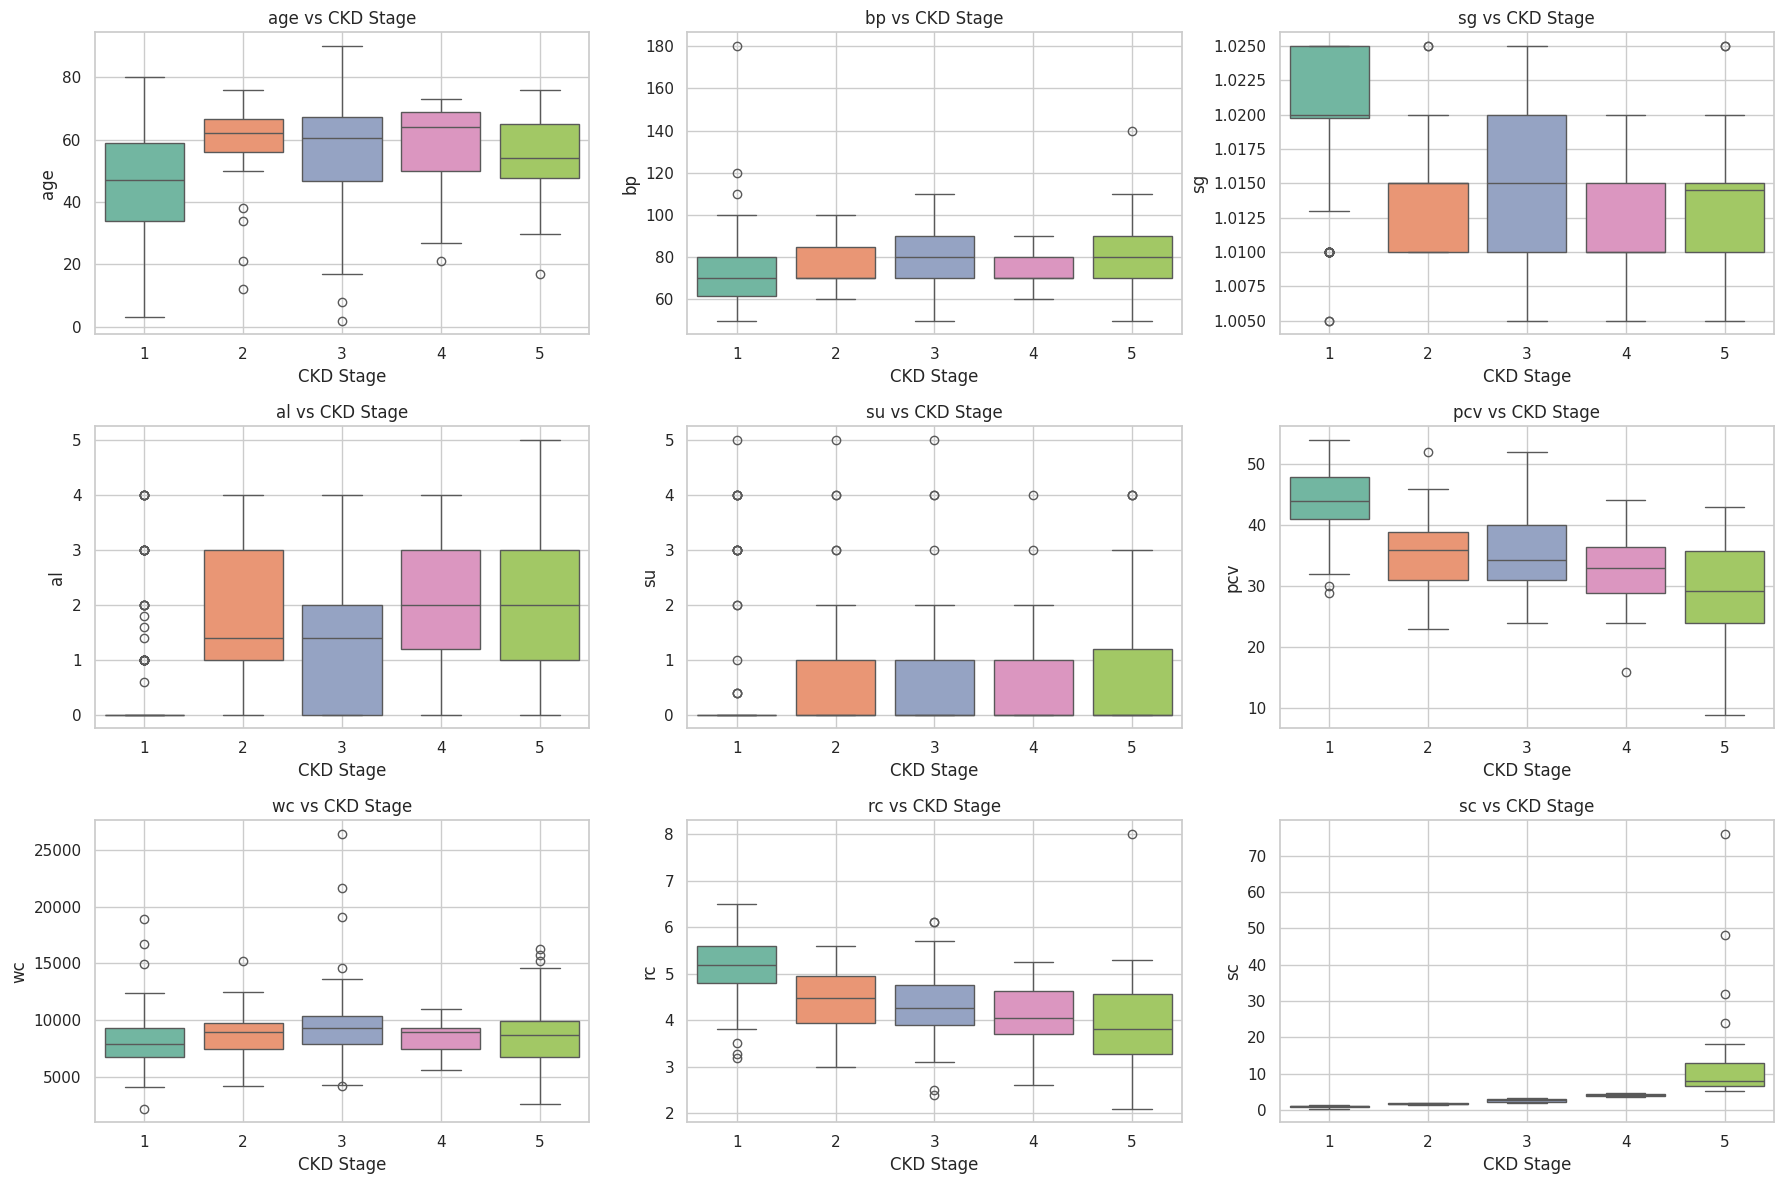

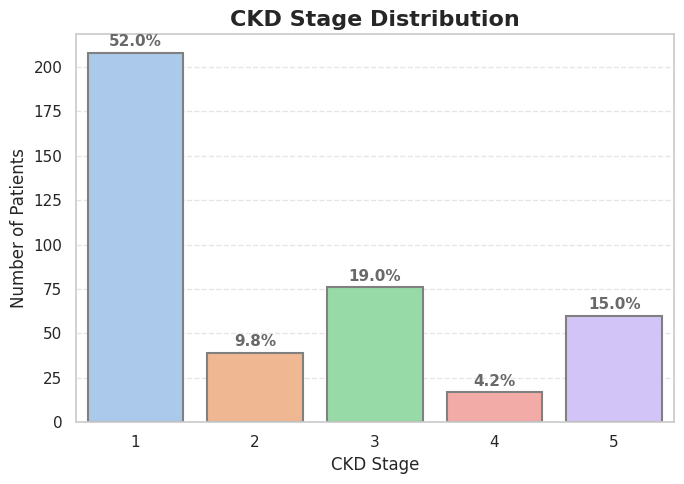

In [15]:
# SECTION 2: Data Preparation and Exploratory Data Analysis (EDA)

print("\nLoading and Preparing Dataset...")

# 1. Load dataset
file_path = '/content/drive/MyDrive/kidney_disease.csv'
df = pd.read_csv(file_path)
print(f"Original dataset shape: {df.shape}")

# 2. Data Cleaning: Handling invalid entries
# Replace special characters and '?' with NaN
df.replace(to_replace=r'\t\?', value=np.nan, regex=True, inplace=True)
df.replace('?', np.nan, inplace=True)

# Remove leading/trailing spaces
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# 3. Checking missing values before coercing
print("\nMissing values BEFORE coercing to numeric:\n", df.isnull().sum())

# 4. Convert selected numeric columns from object to numeric (coerce errors to NaN)
numeric_columns = ['age', 'bp', 'sg', 'al', 'su', 'pcv', 'wc', 'rc', 'sc']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# 5. Checking missing values after coercing
print("\nMissing values AFTER coercing to numeric:\n", df.isnull().sum())

# 6. Encode categorical features using LabelEncoder
from sklearn.preprocessing import LabelEncoder
categorical_features = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
label_enc = LabelEncoder()
for col in categorical_features:
    df[col] = label_enc.fit_transform(df[col].astype(str))  # Encode strings including NaNs as 'nan'

# 7. Drop irrelevant columns BEFORE imputation
df_clean = df.drop(columns=['id', 'classification'], errors='ignore')

# 8. Impute missing values using KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_imputed_array = imputer.fit_transform(df_clean)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_clean.columns)

# 9. Define CKD stages based on serum creatinine
def assign_ckd_stage(sc):
    if sc < 1.5:
        return 1
    elif 1.5 <= sc < 2.0:
        return 2
    elif 2.0 <= sc < 3.5:
        return 3
    elif 3.5 <= sc < 5.0:
        return 4
    else:
        return 5

df_imputed['ckd_stage'] = df_imputed['sc'].apply(assign_ckd_stage)

print("\nCKD Stage distribution after preprocessing:\n", df_imputed['ckd_stage'].value_counts())

# 10. Prepare features and labels
y = LabelEncoder().fit_transform(df_imputed['ckd_stage'])
X = df_imputed.drop(columns=['id', 'classification', 'ckd_stage'], errors='ignore')

# 11. Train-test split with stratification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 12. Feature scaling using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Exploratory Data Analysis (EDA) ---

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create directory to save high-res EDA plots
os.makedirs("eda_highres_plots", exist_ok=True)

# Histograms of numeric features
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df_imputed[col], kde=True, color='steelblue', bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('eda_highres_plots/histograms_highres.png', dpi=300, bbox_inches='tight')
plt.show()

# Boxplots of numeric features vs CKD stages
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.boxplot(x='ckd_stage', y=col, data=df_imputed, palette='Set2', ax=axes[i])
    axes[i].set_title(f'{col} vs CKD Stage')
    axes[i].set_xlabel('CKD Stage')
    axes[i].set_ylabel(col)
    axes[i].grid(True)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('eda_highres_plots/boxplots_highres.png', dpi=300, bbox_inches='tight')
plt.show()

# CKD Stage Distribution
plt.figure(figsize=(7, 5))
stage_counts = df_imputed['ckd_stage'].value_counts().sort_index()
stage_labels = stage_counts.index
stage_values = stage_counts.values
stage_perc = (stage_values / stage_values.sum()) * 100

sns.barplot(
    x=stage_labels,
    y=stage_values,
    palette='pastel',
    edgecolor='gray',
    linewidth=1.5
)

for i, val in enumerate(stage_values):
    plt.text(i, val + 2, f'{stage_perc[i]:.1f}%', ha='center', va='bottom',
             fontsize=11, fontweight='bold', color='dimgray')

plt.title('CKD Stage Distribution', fontsize=16, fontweight='bold')
plt.xlabel('CKD Stage')
plt.ylabel('Number of Patients')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('eda_highres_plots/ckd_stage_distribution_highres.png', dpi=300, bbox_inches='tight')
plt.show()


# Section 3: Hyperparameter Tuning

In this section, I perform hyperparameter tuning for Random Forest, Support Vector Machine (SVM), and Gradient Boosting models using GridSearchCV to find the best model configurations.


In [16]:
# SECTION 3: Hyperparameter Tuning

# Hyperparameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV for Random Forest
rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_params,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)
rf_grid.fit(X_train_scaled, y_train)
rf_best = rf_grid.best_estimator_
print("Best Random Forest Parameters:", rf_grid.best_params_)

# Hyperparameter grid for Support Vector Machine (SVM)
svm_params = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV for SVM
svm_grid = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=svm_params,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)
svm_grid.fit(X_train_scaled, y_train)
svm_best = svm_grid.best_estimator_
print("Best SVM Parameters:", svm_grid.best_params_)

# Hyperparameter grid for Gradient Boosting
gb_params = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# GridSearchCV for Gradient Boosting
gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1
)
gb_grid.fit(X_train_scaled, y_train)
gb_best = gb_grid.best_estimator_
print("Best Gradient Boosting Parameters:", gb_grid.best_params_)

# Predictions on the test set using the best models
rf_pred = rf_best.predict(X_test_scaled)
svm_pred = svm_best.predict(X_test_scaled)
gb_pred = gb_best.predict(X_test_scaled)


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


# Section 4: Deep Learning with EarlyStopping and Class Weights

In this section, I build and train a deep neural network (DNN) for CKD stage classification using class weights to handle class imbalance and EarlyStopping to prevent overfitting.  
I also plot the training and validation accuracy and loss curves.


Training Deep Neural Network with Class Weights...

DNN Model Architecture Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,845 (15.02 KB)

 Trainable params: 3,845 (15.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2376 - loss: 1.6339 - val_accuracy: 0.5375 - val_loss: 1.4119
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4100 - loss: 1.7661 - val_accuracy: 0.5125 - val_loss: 1.3000
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5057 - loss: 1.3299 - val_accuracy: 0.6125 - val_loss: 1.1511
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5489 - loss: 1.2836 - val_accuracy: 0.6500 - val_loss: 1.0550
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5731 - loss: 1.3058 - val_accuracy: 0.6250 - val_loss: 1.0060
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6008 - loss: 1.3329 - val_accuracy: 0.6375 - val_loss: 0.9610
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5731 - loss: 1.2318 - val_accuracy: 0.6500 - val_loss: 0.9250
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6271 - loss: 1.1285 - val_accuracy: 0.

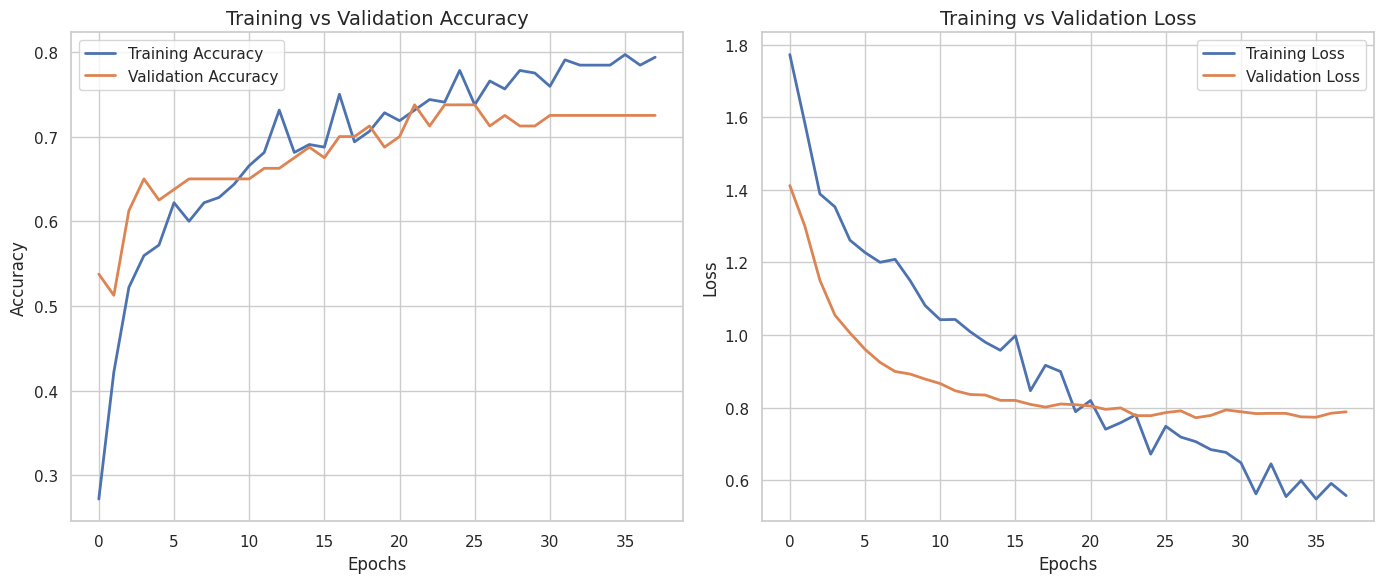

In [31]:
# SECTION 4: Deep Learning with EarlyStopping and Class Weights

print("Training Deep Neural Network with Class Weights...")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# One-hot encode labels for multi-class classification
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Build a lightweight MLP model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 output classes for CKD stages
])

# Print and Save model summary (for report Figure 5.1)
print("\nDNN Model Architecture Summary:")
model.summary()

# Save model summary to text file
with open('dnn_model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Configure EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_test_scaled, y_test_cat),
    epochs=100,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate and make predictions
dl_probs = model.predict(X_test_scaled)
dl_pred = np.argmax(dl_probs, axis=1)

# Plot training accuracy and loss
plt.figure(figsize=(14, 6))  # Slightly bigger figure for better quality

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot in high resolution
plt.savefig('dnn_training_validation_curves_highres.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


# Section 5: Evaluation Metrics

In this section, I evaluate and compare the performance of all trained models using accuracy, F1 score, precision, and recall.  
I also visualize the comparison using a high-resolution bar plot.



 Model Performance Comparison:
                    Model  Accuracy  F1 Score  Precision  Recall
0           Random Forest    0.9125  0.895673   0.896429  0.9125
1  Support Vector Machine    0.7250  0.725917   0.733750  0.7250
2       Gradient Boosting    0.9875  0.987792   0.988889  0.9875
3     Deep Neural Network    0.7250  0.708677   0.721767  0.7250


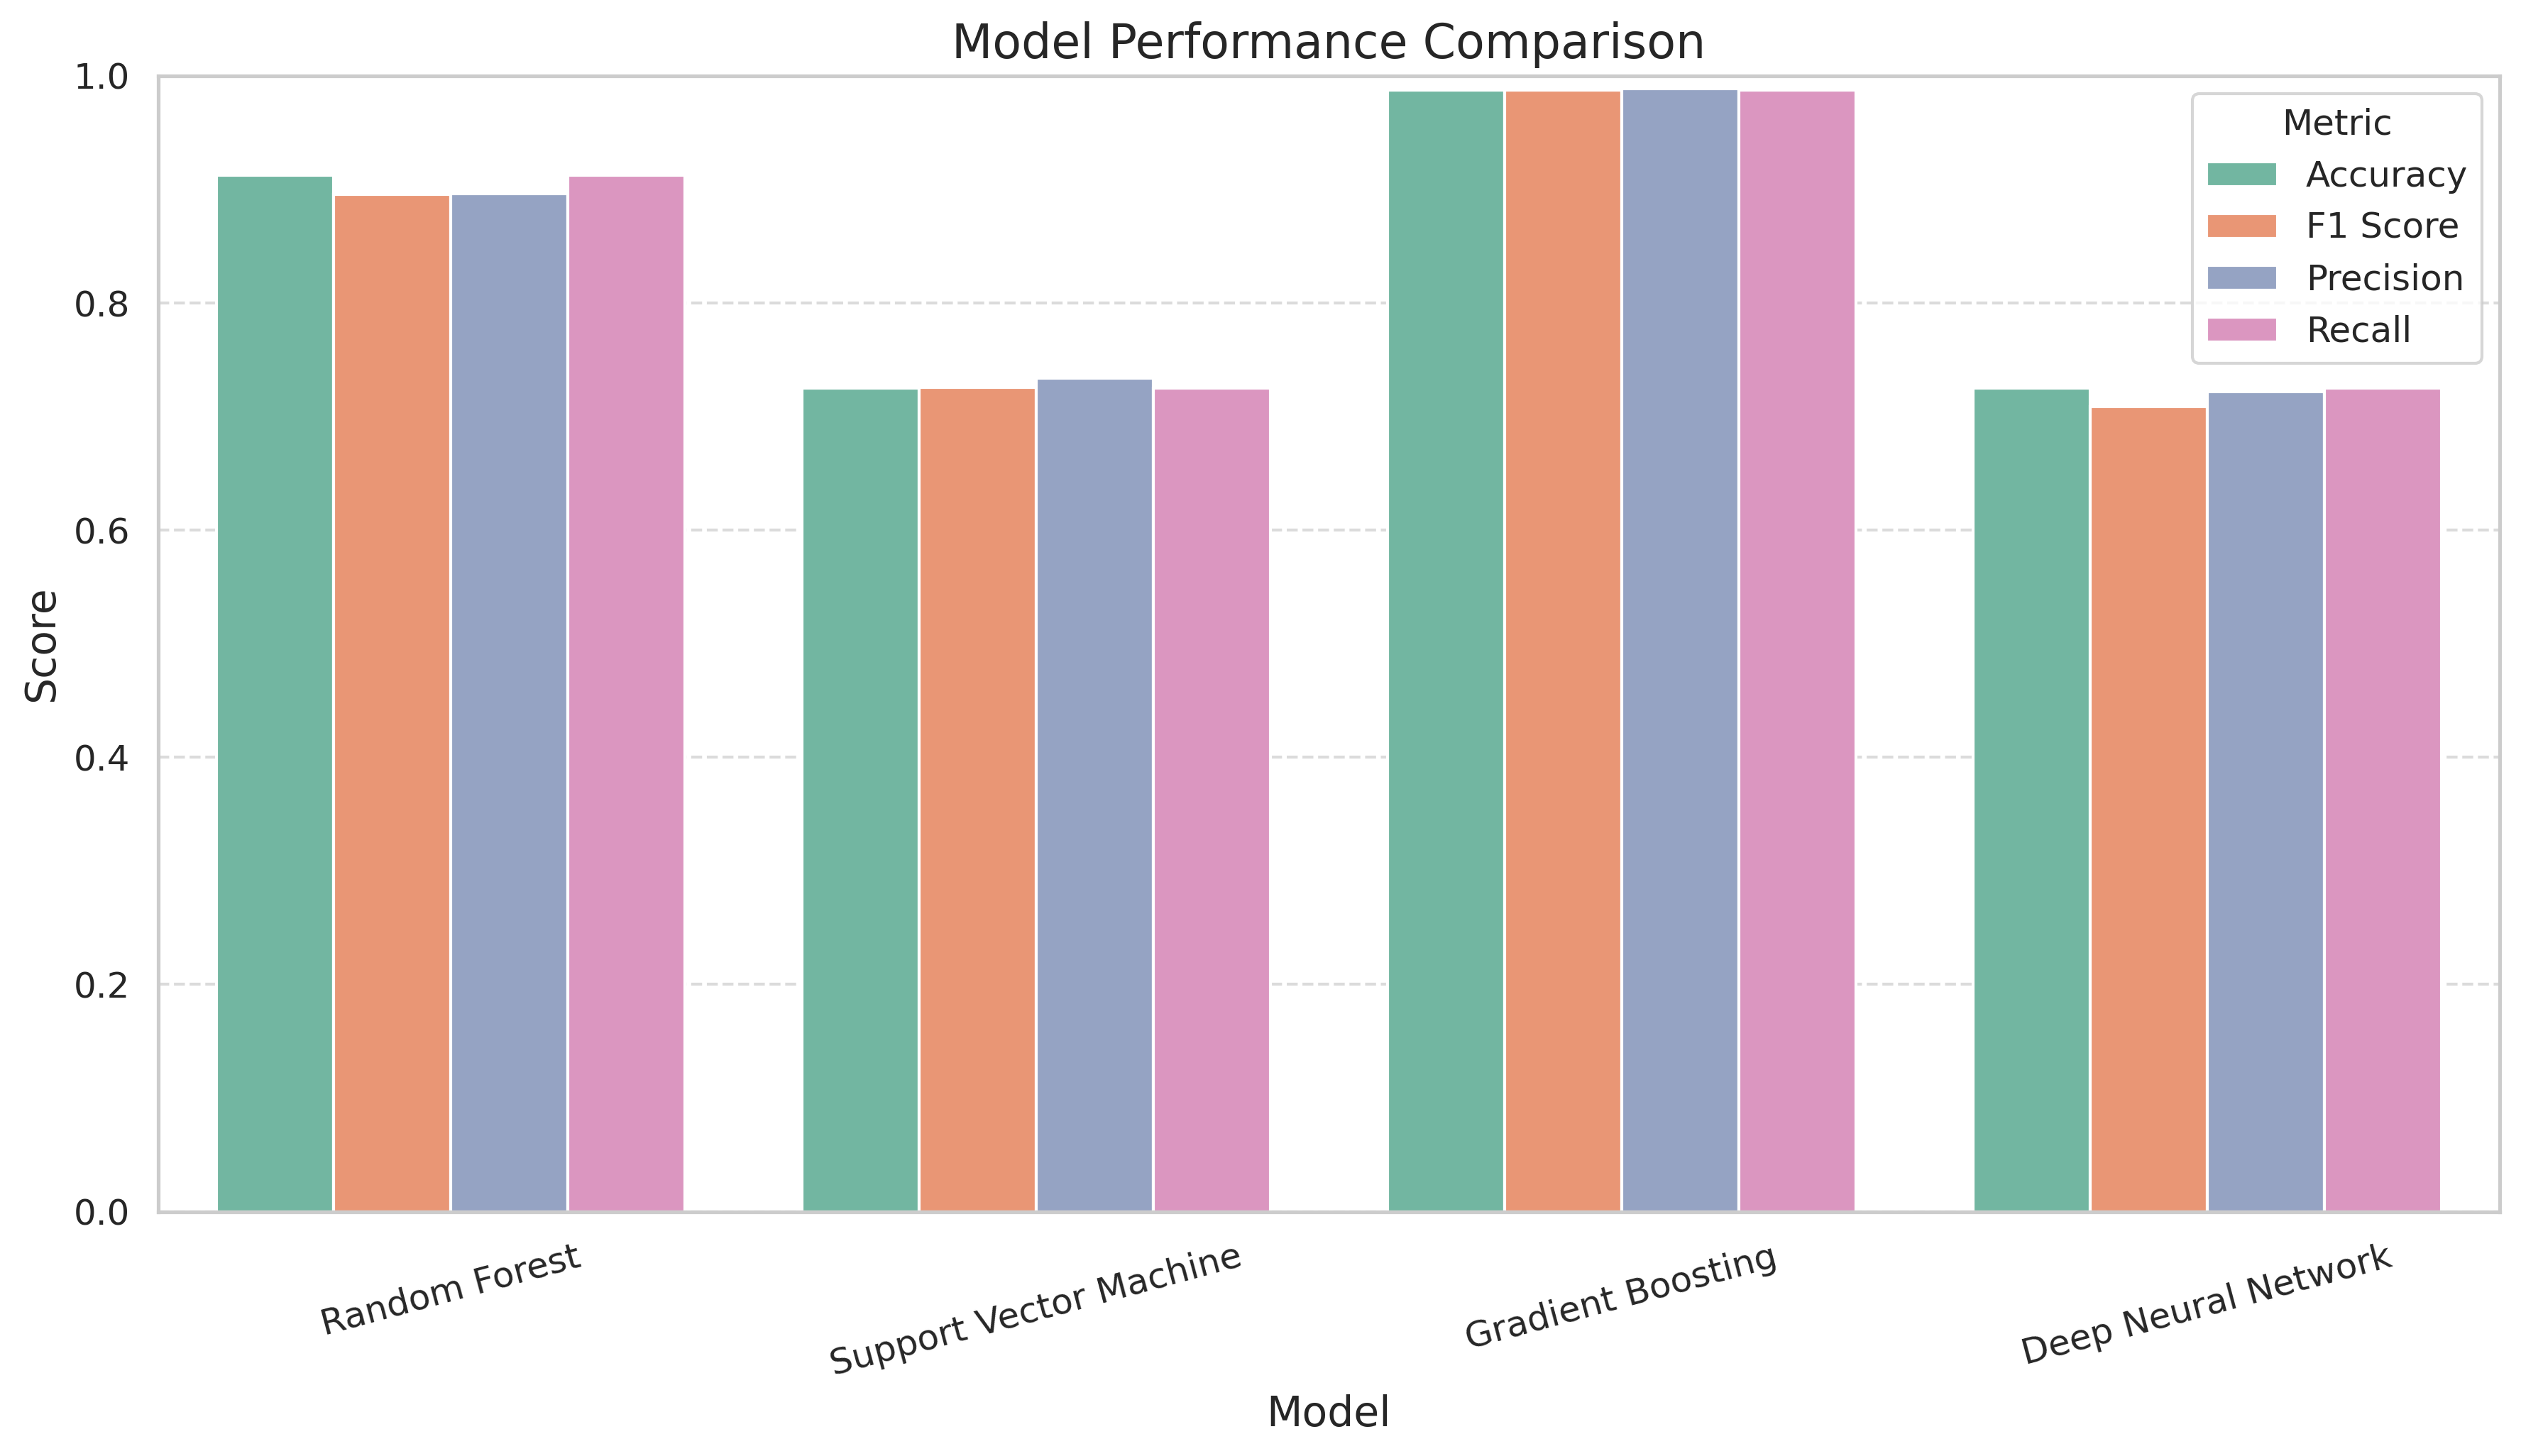

In [32]:
# SECTION 5: Evaluation Metrics (High-Resolution Plot)

print("\n Model Performance Comparison:")

# Store predictions from all models
model_predictions = {
    "Random Forest": rf_pred,
    "Support Vector Machine": svm_pred,
    "Gradient Boosting": gb_pred,
    "Deep Neural Network": dl_pred
}

# Initialize results list
results = []

# Compute evaluation metrics for each model
for model_name, y_pred in model_predictions.items():
    results.append({
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted')
    })

# Create results dataframe
results_df = pd.DataFrame(results)
print(results_df)

# Plot model performance comparison
plt.figure(figsize=(12, 7), dpi=300)  # High-res figure (300 dpi)

sns.barplot(
    data=results_df.melt(id_vars='Model'),
    x='Model', y='value', hue='variable',
    palette='Set2'
)

plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Model", fontsize=14)
plt.ylim(0, 1)
plt.legend(title="Metric", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save the figure
plt.savefig("model_performance_comparison_highres.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Section 6: Confusion Matrices

In this section, I generate and visualize both raw and normalized confusion matrices for each model to analyze classification performance in more detail.



Confusion Matrices (Raw and Normalized):


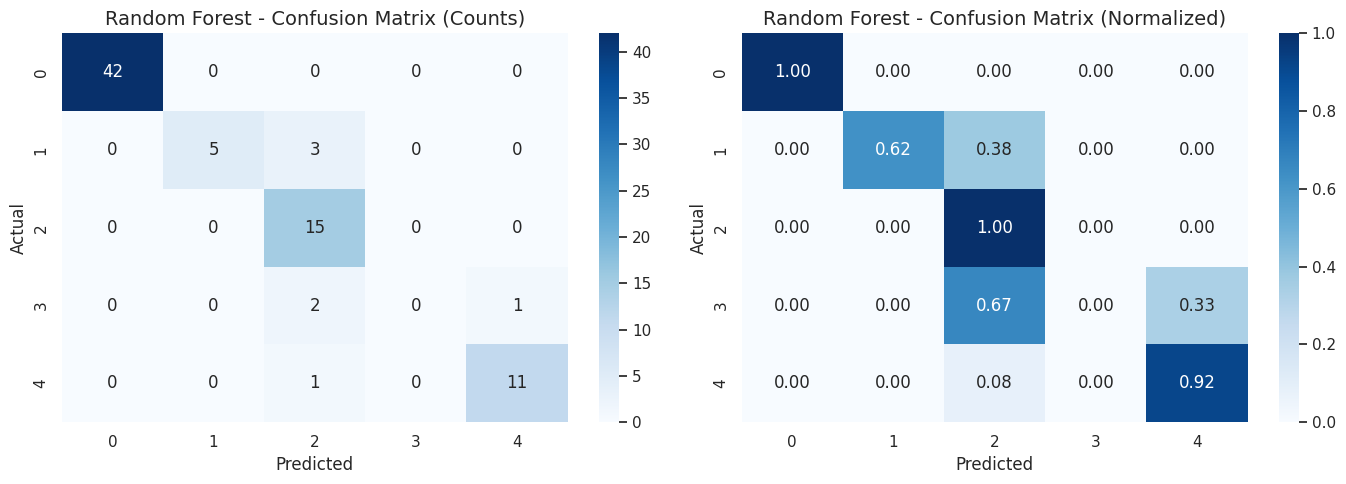

Saved high-resolution confusion matrices for Random Forest as random_forest_confusion_matrices_highres.png



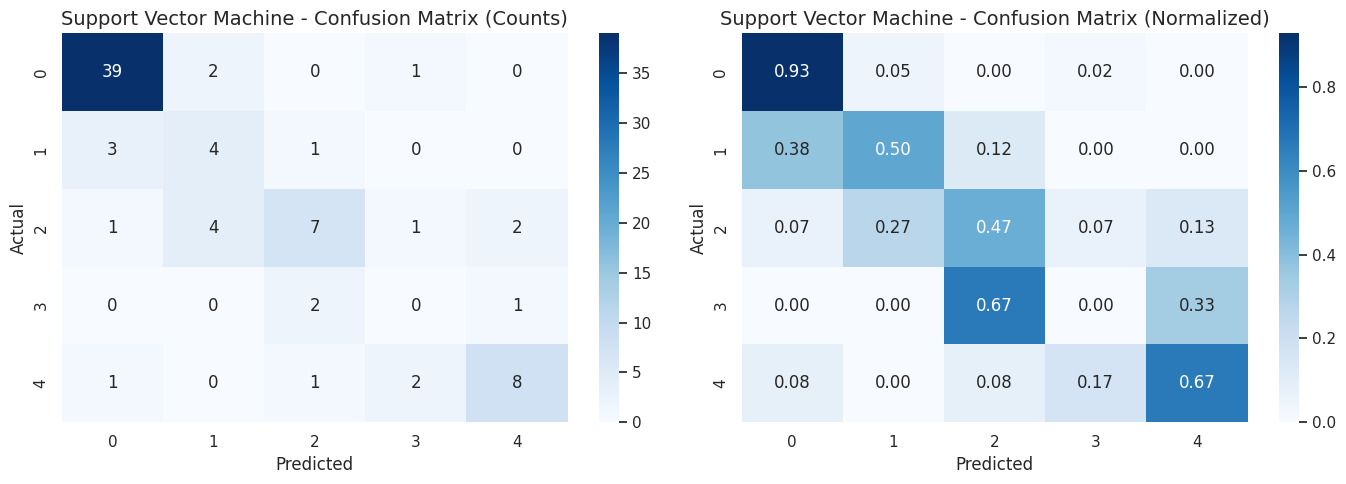

Saved high-resolution confusion matrices for Support Vector Machine as support_vector_machine_confusion_matrices_highres.png



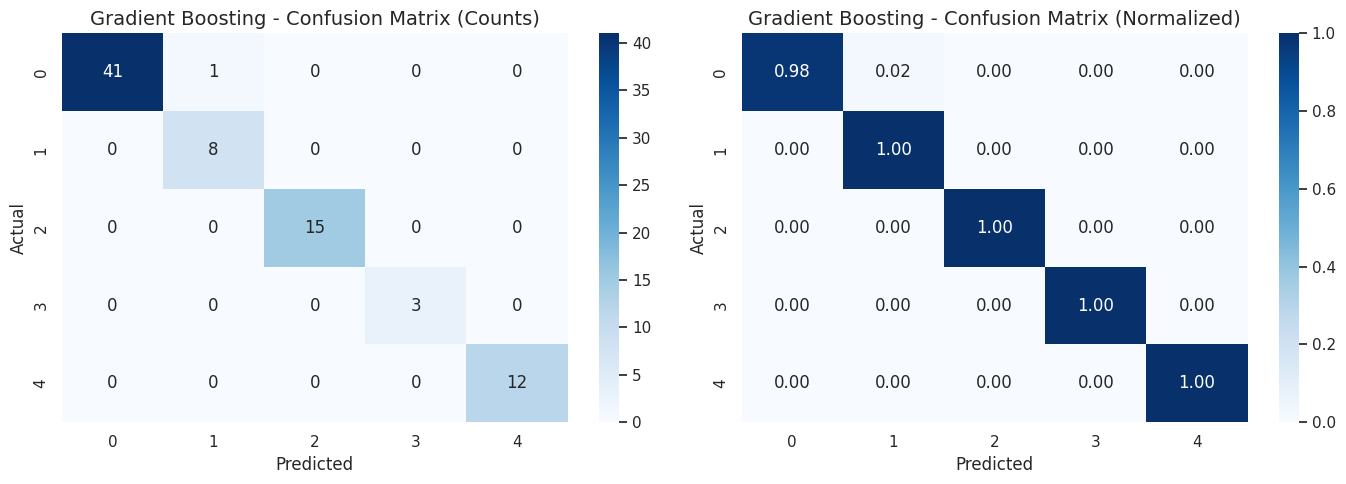

Saved high-resolution confusion matrices for Gradient Boosting as gradient_boosting_confusion_matrices_highres.png



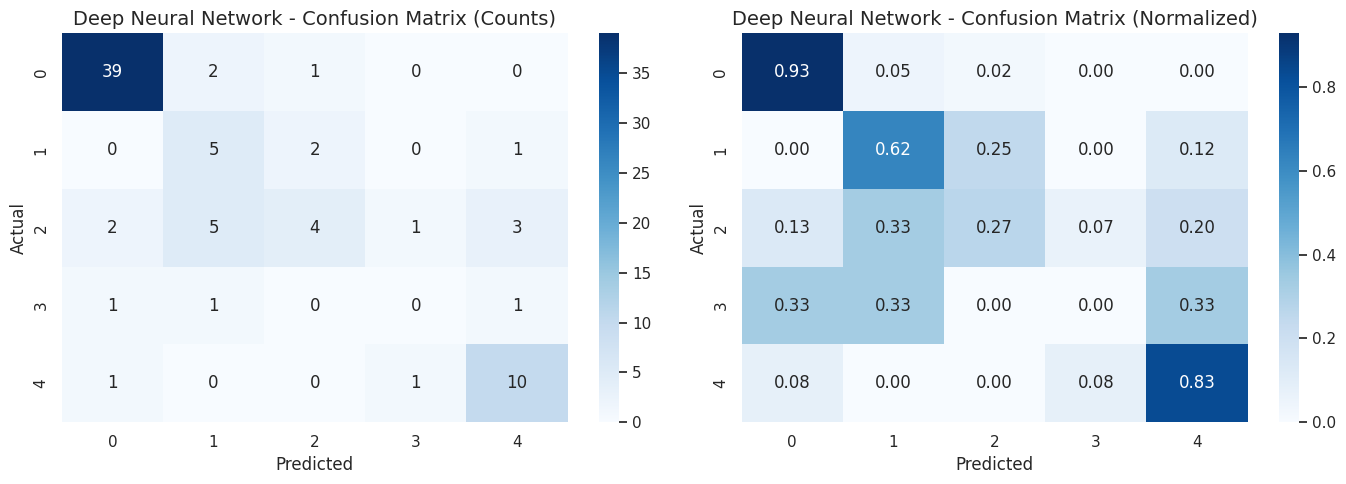

Saved high-resolution confusion matrices for Deep Neural Network as deep_neural_network_confusion_matrices_highres.png



In [33]:
# SECTION 6: Confusion Matrices

print("\nConfusion Matrices (Raw and Normalized):")

# Loop through each model to display and save its confusion matrix
for model_name, y_pred in model_predictions.items():
    # Raw confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Normalized confusion matrix (row-wise)
    cm_norm = confusion_matrix(y_test, y_pred, normalize='true')

    plt.figure(figsize=(14, 5))  # Bigger figure for high-quality

    # Plot raw confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix (Counts)', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    # Plot normalized confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)

    plt.tight_layout()

    # Save the figure
    filename = f"{model_name.replace(' ', '_').lower()}_confusion_matrices_highres.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Display the figure
    plt.show()

    print(f"Saved high-resolution confusion matrices for {model_name} as {filename}\n")


# Section 7: Feature Importances

In this section, I extract and visualize the top important features from the Random Forest and Gradient Boosting models to understand which features contribute most to CKD stage prediction.



Feature Importances from Tree-Based Models:

Top Features - Random Forest:
   Feature  Importance
0      sc    0.330642
1      bu    0.157091
2    hemo    0.071039
3     pcv    0.054295
4      al    0.048750
5      rc    0.040889
6     sod    0.033790
7      sg    0.032830
8     age    0.029539
9     pot    0.028072


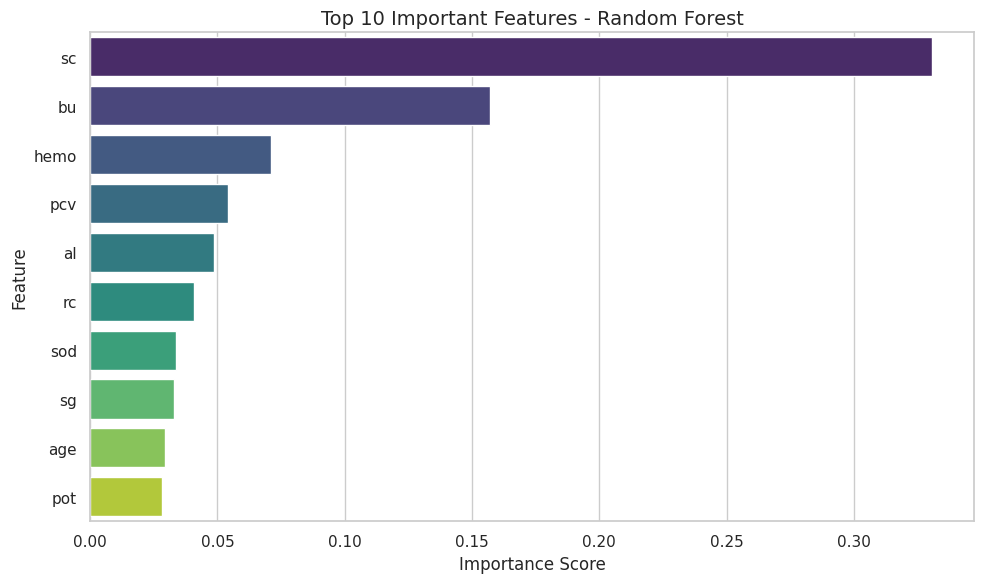

Saved high-resolution feature importance plot for Random Forest as random_forest_feature_importances_highres.png


Top Features - Gradient Boosting:
   Feature    Importance
0      sc  1.000000e+00
1      wc  4.401305e-16
2     pot  1.323607e-16
3     bgr  1.146480e-16
4      bu  1.142366e-16
5      rc  1.041656e-16
6     pcv  6.345380e-17
7    hemo  2.514456e-17
8     age  4.813340e-18
9      su  2.369644e-18


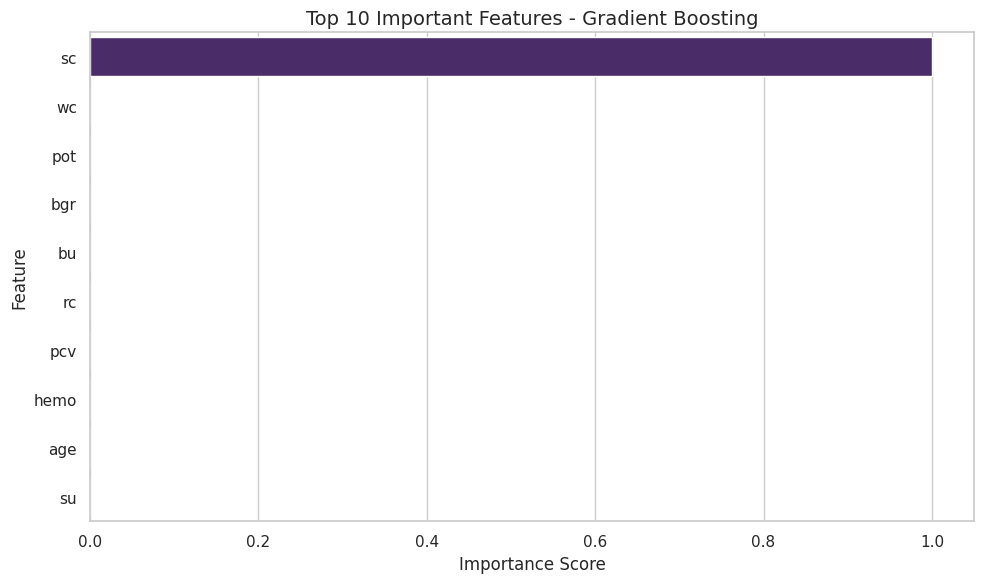

Saved high-resolution feature importance plot for Gradient Boosting as gradient_boosting_feature_importances_highres.png



In [34]:
# SECTION 7: Feature Importances

print("\nFeature Importances from Tree-Based Models:")

# Zip model names and model objects
for model_name, model in zip(["Random Forest", "Gradient Boosting"], [rf_best, gb_best]):
    # Ensure the model has feature_importances_ attribute
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        feature_names = X.columns
        indices = np.argsort(importances)[::-1]  # Sort descending

        # Create a sorted dataframe for easy viewing
        sorted_features = pd.DataFrame({
            'Feature': feature_names[indices],
            'Importance': importances[indices]
        })

        print(f"\nTop Features - {model_name}:\n", sorted_features.head(10))

        # Plot the top 10 important features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=sorted_features.head(10), palette='viridis')
        plt.title(f"Top 10 Important Features - {model_name}", fontsize=14)
        plt.xlabel("Importance Score", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.tight_layout()

        # Save the figure in high resolution
        filename = f"{model_name.replace(' ', '_').lower()}_feature_importances_highres.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')

        # Show the figure
        plt.show()

        print(f"Saved high-resolution feature importance plot for {model_name} as {filename}\n")


# Section 8: SHAP Summary Plot

In this section, I use SHAP (SHapley Additive exPlanations) to interpret the Random Forest model by analyzing feature importance through a summary plot.



SHAP Summary Plot for Random Forest
Combined SHAP shape: (80, 24)
X_test_df shape: (80, 24)


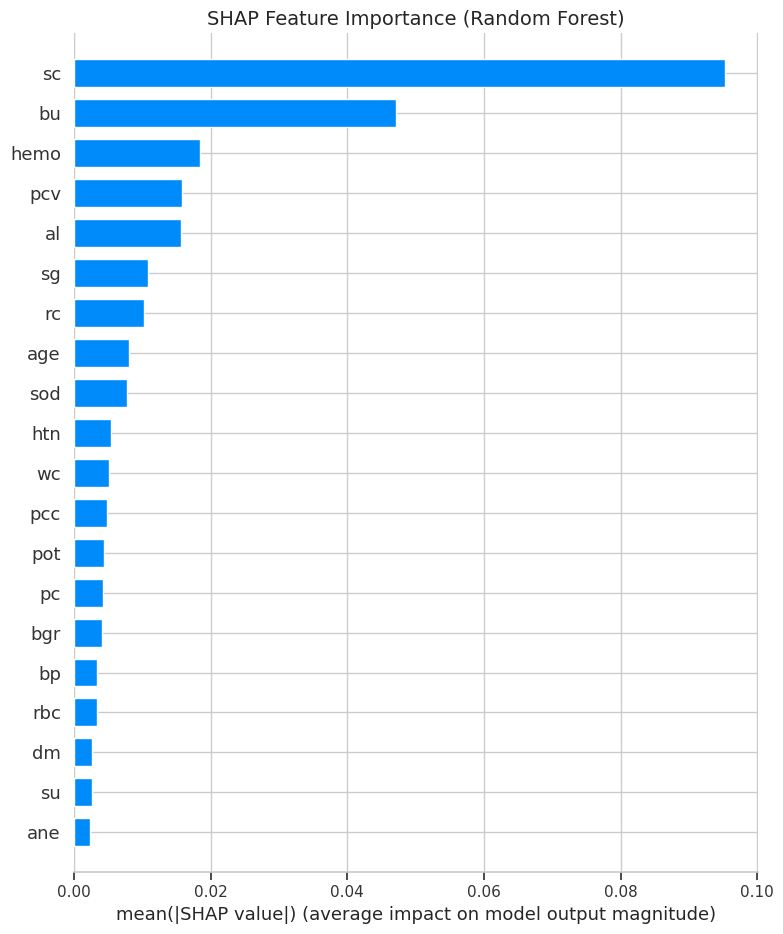


Saved high-resolution SHAP summary plot as 'shap_summary_random_forest_highres.png'


In [35]:
print("\nSHAP Summary Plot for Random Forest")

import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Fit a simpler model for interpretability
rf_shap = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_shap.fit(X_train, y_train)

# Create test DataFrame
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# TreeExplainer for multiclass
explainer = shap.TreeExplainer(rf_shap)
shap_values = explainer.shap_values(X_test_df)  # shape: (samples, features, classes)

# Combine across classes (mean absolute SHAP values)
shap_values_combined = np.mean(np.abs(shap_values), axis=2)

# Confirm matching shapes
print("Combined SHAP shape:", shap_values_combined.shape)
print("X_test_df shape:", X_test_df.shape)

# Plot summary (as a bar plot)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_combined, X_test_df, plot_type='bar', show=False)

# Save the SHAP plot
plt.title("SHAP Feature Importance (Random Forest)", fontsize=14)
plt.tight_layout()
plt.savefig('shap_summary_random_forest_highres.png', dpi=300, bbox_inches='tight')

# Finally, show the plot
plt.show()

print("\nSaved high-resolution SHAP summary plot as 'shap_summary_random_forest_highres.png'")


# Section 9: Cross-Validation Scores

In this section, I perform 5-fold cross-validation on the training set to evaluate the stability and generalization performance of the Random Forest, Gradient Boosting, and Support Vector Machine models.


In [36]:
# SECTION 9: Cross-Validation Scores

print("\n 5-Fold Cross-Validation Accuracy (on Training Set):")

# Define models and labels
cv_models = {
    "Random Forest": rf_best,
    "Gradient Boosting": gb_best,
    "Support Vector Machine": svm_best
}

# Compute and display mean ± std of accuracy for each model
for model_name, model in cv_models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{model_name}: {scores.mean():.4f} ± {scores.std():.4f}")



 5-Fold Cross-Validation Accuracy (on Training Set):
Random Forest: 0.9313 ± 0.0212
Gradient Boosting: 1.0000 ± 0.0000
Support Vector Machine: 0.7719 ± 0.0598
